In [2]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier
import joblib
import warnings
warnings.filterwarnings('ignore', category=UserWarning)
# import custom functions from src/utils.py
import sys
sys.path.append('../')
from src.utils import remove_correlated_features
from src.utils import plot_correlation_heatmap
from src.utils import remove_low_variance_features
from src.utils import plot_pca
from src.utils import plot_feature_importances
from src.utils import confusion_matrix_heatmap

In [3]:
digits = load_digits()

In [4]:
digits.data[2]

array([ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
       14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
        1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
        0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  3., 13., 16.,
       16., 11.,  5.,  0.,  0.,  0.,  0.,  3., 11., 16.,  9.,  0.])

In [5]:
digits.data.shape

(1797, 64)

In [6]:
# convert the data to a pandas dataframe
import pandas as pd
df = pd.DataFrame(digits.data, columns=['feature_' + str(i) for i in range(1, 65)])

# add the target column to the dataframe
df['target'] = digits.target

# check the head of the dataframe
df.head()

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,target
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


In [7]:
features_df = df.drop('target', axis=1)
target_df = df['target']

In [8]:
features_df.shape

(1797, 64)

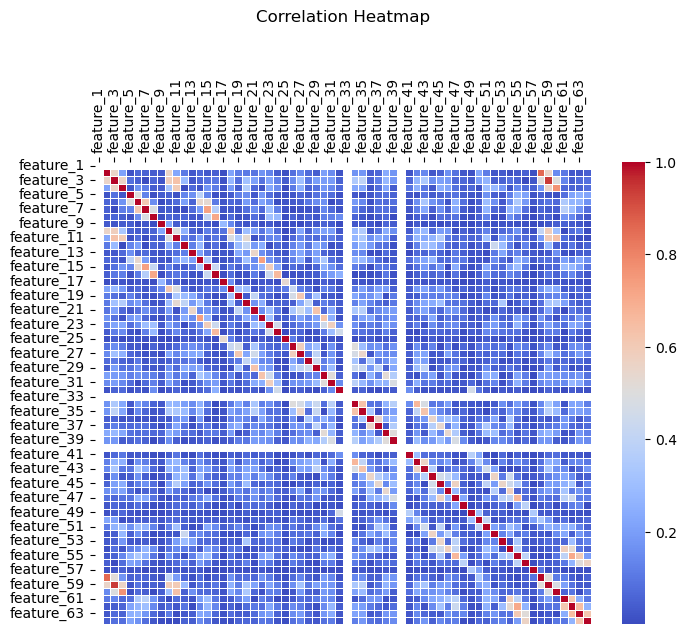

In [9]:
plot_correlation_heatmap(features_df, annot=False)

In [10]:
features_df = remove_correlated_features(features_df, 0.9)
features_df.head()
print(features_df.shape)

(1797, 63)


In [11]:
# Check for balance in the target variable
target_df.value_counts()

target
3    183
1    182
5    182
4    181
6    181
9    180
7    179
0    178
2    177
8    174
Name: count, dtype: int64

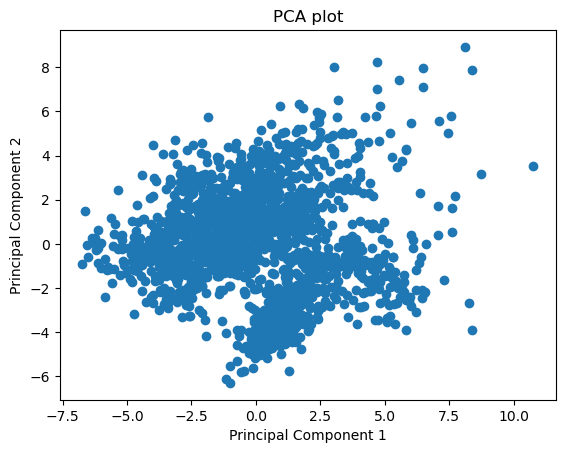

In [12]:
plot_pca(features_df)

In [13]:
features_df = remove_low_variance_features(features_df, 0.01)
print(features_df.shape)
features_df.head()

(1797, 48)


,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_10,feature_11,feature_12,feature_13,...,feature_52,feature_53,feature_54,feature_55,feature_58,feature_60,feature_61,feature_62,feature_63,feature_64
0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,13.0,15.0,10.0,...,5.0,10.0,12.0,0.0,0.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,11.0,16.0,...,16.0,16.0,6.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,4.0,15.0,12.0,0.0,0.0,3.0,16.0,15.0,...,16.0,16.0,11.0,5.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,7.0,15.0,13.0,1.0,0.0,8.0,13.0,6.0,15.0,...,4.0,5.0,14.0,9.0,0.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,7.0,8.0,...,3.0,15.0,10.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


In [14]:
# Scale the features using MaxMinScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_features_df = scaler.fit_transform(features_df)

In [15]:
X = scaled_features_df
y = target_df.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:

# Use logistic regression to classify the data
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(max_iter=1000, multi_class='auto',  solver='lbfgs', tol=0.0001)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.9666666666666667


<h2 style="color:blue" align="center">Model Selection, Feature Engineering and Hyperparameter Optimization</h2>

In this section, I seek to select the best model, features (and/or feature combinations) and hyperparameters. This section will include:
<ol>
    <li>K-fold Cross Validation</li>
    <li>Feature Engineering (Selecting the best combination of features using selectKBest)</li>
    <li>Hyperparameter Optimization (Bayesian Optimization using hyperopt) </li>
</ol>

In [45]:
# Search space containing models and their hyperparameters
search_space = {
    'model': hp.choice('model', [
        {
            'type': 'RandomForestClassifier',
            'n_estimators': scope.int(hp.quniform('rf_n_estimators', 50, 300, 10)), 
            'max_depth': scope.int(hp.quniform('rf_max_depth', 3, 20, 1)),  
            'max_features': hp.choice('rf_max_features', ['sqrt', 'log2', None]), 
        },
        {
            'type': 'LogisticRegression',
            'C': hp.uniform('lr_C', 0.1, 1.0),
        },
        {
            'type': 'XGBClassifier',
            'n_estimators': scope.int(hp.quniform('xgb_n_estimators', 50, 300, 10)),
            'max_depth': scope.int(hp.quniform('xgb_max_depth', 3, 10, 1)),
            'learning_rate': hp.uniform('xgb_learning_rate', 0.01, 0.3),
        },
        {
            'type': 'LGBMClassifier',
            'n_estimators': scope.int(hp.quniform('lgbm_n_estimators', 50, 300, 10)),
            'max_depth': scope.int(hp.quniform('lgbm_max_depth', -1, 20, 1)), 
            'learning_rate': hp.uniform('lgbm_learning_rate', 0.01, 0.3),
            'num_leaves': scope.int(hp.quniform('lgbm_num_leaves', 20, 40, 1)),
        },
        {
            'type': 'CatBoostClassifier',
            'iterations': scope.int(hp.quniform('cat_iterations', 50, 300, 10)),
            'depth': scope.int(hp.quniform('cat_depth', 3, 10, 1)),
            'learning_rate': hp.uniform('cat_learning_rate', 0.01, 0.3),
        },
        {
            'type': 'GaussianNB',
        },
        {
            'type': 'KNeighborsClassifier',
            'n_neighbors': scope.int(hp.quniform('knn_n_neighbors', 3, 15, 1)),
            'weights': hp.choice('knn_weights', ['uniform', 'distance']),
        },
        {
            'type': 'DecisionTreeClassifier',
            'max_depth': scope.int(hp.quniform('dt_max_depth', 3, 20, 1)),
            'min_samples_split': scope.int(hp.quniform('dt_min_samples_split', 2, 10, 1)),
        },
        {
            'type': 'AdaBoostClassifier',
            'n_estimators': scope.int(hp.quniform('ada_n_estimators', 50, 300, 10)),
            'learning_rate': hp.uniform('ada_learning_rate', 0.01, 1.0),
        },
        {
            'type': 'GradientBoostingClassifier',
            'n_estimators': scope.int(hp.quniform('gb_n_estimators', 50, 300, 10)),
            'learning_rate': hp.uniform('gb_learning_rate', 0.01, 0.3),
            'max_depth': scope.int(hp.quniform('gb_max_depth', 3, 10, 1)),
        },
        {
            'type': 'ExtraTreesClassifier',
            'n_estimators': scope.int(hp.quniform('et_n_estimators', 50, 300, 10)),
            'max_depth': scope.int(hp.quniform('et_max_depth', 3, 20, 1)),
            'max_features': hp.choice('et_max_features', ['sqrt', 'log2', None]),
        },
    ]),
    'polynomialfeatures_degree': hp.choice('polynomialfeatures_degree', range(1, 3)),
    'selectkbest_k': hp.choice('selectkbest_k', range(1, 49)), # the features are 48 after removing correlated features
}

In [46]:

# Objective function to minimize
def objective(params):
    model_name = params['model']['type']
    del params['model']['type']
    
    if model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**params['model'])
    elif model_name == 'LogisticRegression':
        model = LogisticRegression(**params['model'], max_iter=1000)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**params['model'])
    elif model_name == 'LGBMClassifier':
        model = LGBMClassifier(**params['model'],verbosity=-1)
    elif model_name == 'CatBoostClassifier':
        model = CatBoostClassifier(**params['model'], verbose=False)
    elif model_name == 'GaussianNB':
        model = GaussianNB()
    elif model_name == 'KNeighborsClassifier':
        model = KNeighborsClassifier(**params['model'])
    elif model_name == 'DecisionTreeClassifier':
        model = DecisionTreeClassifier(**params['model'])
    elif model_name == 'AdaBoostClassifier':
        model = AdaBoostClassifier(**params['model'])
    elif model_name == 'GradientBoostingClassifier':
        model = GradientBoostingClassifier(**params['model'])
    elif model_name == 'ExtraTreesClassifier':
        model = ExtraTreesClassifier(**params['model'])

    model_pipeline = make_pipeline(
        PolynomialFeatures(degree=params['polynomialfeatures_degree']),
        SelectKBest(f_regression, k=params['selectkbest_k']),
        model
    )
    
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='neg_log_loss')
    log_loss_cv = -scores.mean() 
    
    return {
        'loss': log_loss_cv,
        'status': STATUS_OK,
        'model_pipeline': model_pipeline,
    }

trials = Trials()
best = fmin(objective, search_space, algo=tpe.suggest, max_evals=150, trials=trials)

100%|██████████| 150/150 [22:47<00:00,  9.11s/trial, best loss: 0.08616368888291634]


In [47]:
best_params = space_eval(search_space, best)
best_params

{'model': {'depth': 6,
  'iterations': 300,
  'learning_rate': 0.2999218234269526,
  'type': 'CatBoostClassifier'},
 'polynomialfeatures_degree': 2,
 'selectkbest_k': 45}

<h2 style="color:blue" align="center">Model Re-training, Inference, Evaluation and Saving</h2>

In this section, I will re-train with the best model and hyper-paramaters from the previous secction. This section will include:
<ol>
    <li>Model Re-training</li>
    <li>Feature Importance</li>
    <li>Model Saving</li>
</ol>

In [48]:
best_params['model']

{'depth': 6,
 'iterations': 300,
 'learning_rate': 0.2999218234269526,
 'type': 'CatBoostClassifier'}

In [49]:
# Rebuild the pipeline with the best parameters
best_model_name = best_params['model']['type']
del best_params['model']['type']

if best_model_name == 'RandomForestClassifier':
    best_model = RandomForestClassifier(**best_params['model'])
elif best_model_name == 'LogisticRegression':
    best_model = LogisticRegression(**best_params['model'])
elif best_model_name == 'XGBClassifier':
    best_model = XGBClassifier(**best_params['model'])
elif best_model_name == 'LGBMClassifier':
    best_model = LGBMClassifier(**best_params['model'],verbosity=-1, force_row_wise=True)
elif best_model_name == 'CatBoostClassifier':
    best_model = CatBoostClassifier(**best_params['model'], verbose=False)
elif best_model_name == 'GaussianNB':
    best_model = GaussianNB()
elif best_model_name == 'KNeighborsClassifier':
    best_model = KNeighborsClassifier(**best_params['model'])
elif best_model_name == 'DecisionTreeClassifier':
    best_model = DecisionTreeClassifier(**best_params['model'])
elif best_model_name == 'AdaBoostClassifier':
    best_model = AdaBoostClassifier(**best_params['model'])
elif best_model_name == 'GradientBoostingClassifier':
    best_model = GradientBoostingClassifier(**best_params['model'])
elif best_model_name == 'ExtraTreesClassifier':
    best_model = ExtraTreesClassifier(**best_params['model'])


# Create the pipeline with the best parameters
best_model_pipeline = make_pipeline(
    PolynomialFeatures(degree=best_params['polynomialfeatures_degree']),  # Use the best degree
    SelectKBest(f_regression, k=best_params['selectkbest_k']),  # Use the best k features
    best_model
)

In [50]:
# Fit the pipeline on the full training data
best_model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('selectkbest',
                 SelectKBest(k=45,
                             score_func=<function f_regression at 0x0000025ED40B8550>)),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x0000025ED8791F10>)])

In [51]:
best_model_pipeline.score(X_test, y_test)

0.975

In [52]:
y_pred = best_model_pipeline.predict(X_test)

In [53]:
selected_features_indices = best_model_pipeline.named_steps['selectkbest'].get_support(indices=True)
poly = best_model_pipeline.named_steps['polynomialfeatures']
transformed_feature_names = poly.get_feature_names_out(input_features=features_df.columns)
# map the selected indices to the transformed feature names
selected_features = transformed_feature_names[selected_features_indices]
selected_features

array(['feature_53', 'feature_4 feature_53', 'feature_11 feature_28',
       'feature_11 feature_29', 'feature_11 feature_36',
       'feature_12 feature_53', 'feature_13^2', 'feature_13 feature_52',
       'feature_13 feature_53', 'feature_13 feature_54',
       'feature_13 feature_61', 'feature_14 feature_28',
       'feature_14 feature_34', 'feature_14 feature_36',
       'feature_19 feature_28', 'feature_19 feature_29',
       'feature_19 feature_36', 'feature_20 feature_53',
       'feature_21 feature_53', 'feature_22 feature_28',
       'feature_22 feature_29', 'feature_22 feature_34',
       'feature_22 feature_36', 'feature_23 feature_29',
       'feature_26 feature_39', 'feature_26 feature_43',
       'feature_27 feature_29', 'feature_28 feature_30',
       'feature_29 feature_30', 'feature_29 feature_31',
       'feature_29 feature_38', 'feature_29 feature_39',
       'feature_30 feature_36', 'feature_31 feature_43',
       'feature_34 feature_51', 'feature_34 feature_54',
  

In [54]:
# Get the feature importances
if best_model_name == 'RandomForestClassifier':
    feature_importances = best_model_pipeline.named_steps['randomforestclassifier'].feature_importances_
elif best_model_name == 'XGBClassifier':
    feature_importances = best_model_pipeline.named_steps['xgbclassifier'].feature_importances_
elif best_model_name == 'LGBMClassifier':
    feature_importances = best_model_pipeline.named_steps['lgbmclassifier'].feature_importances_
elif best_model_name == 'CatBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['catboostclassifier'].feature_importances_
elif best_model_name == 'DecisionTreeClassifier':
    feature_importances = best_model_pipeline.named_steps['decisiontreeclassifier'].feature_importances_
elif best_model_name == 'AdaBoostClassifier':
    feature_importances = best_model_pipeline.named_steps['adaboostclassifier'].feature_importances_
elif best_model_name == 'GradientBoostingClassifier':
    feature_importances = best_model_pipeline.named_steps['gradientboostingclassifier'].feature_importances_
elif best_model_name == 'ExtraTreesClassifier':
    feature_importances = best_model_pipeline.named_steps['extratreesclassifier'].feature_importances_

feature_importances
# map the feature importances to the selected features
selected_features_importances = pd.Series(feature_importances, index=selected_features)
# Sort the features by importance
selected_features_importances = selected_features_importances.sort_values(ascending=False)
selected_features_importances

feature_11 feature_29    8.101173
feature_13 feature_54    7.666704
feature_29 feature_38    5.846908
feature_52 feature_61    5.243838
feature_22 feature_28    4.982717
feature_20 feature_53    4.705099
feature_28 feature_30    4.609774
feature_27 feature_29    4.290716
feature_26 feature_39    4.220548
feature_19 feature_28    3.973174
feature_22 feature_36    3.027524
feature_21 feature_53    2.682913
feature_53 feature_62    2.637697
feature_19 feature_36    2.621407
feature_29 feature_39    2.546158
feature_51 feature_53    2.356417
feature_14 feature_36    2.314793
feature_22 feature_29    2.115966
feature_11 feature_28    1.965910
feature_13 feature_52    1.933843
feature_14 feature_28    1.584896
feature_11 feature_36    1.570100
feature_22 feature_34    1.420448
feature_34 feature_54    1.305774
feature_26 feature_43    1.260374
feature_31 feature_43    1.230048
feature_13 feature_61    1.224024
feature_4 feature_53     1.213040
feature_53 feature_60    1.212130
feature_36 fea

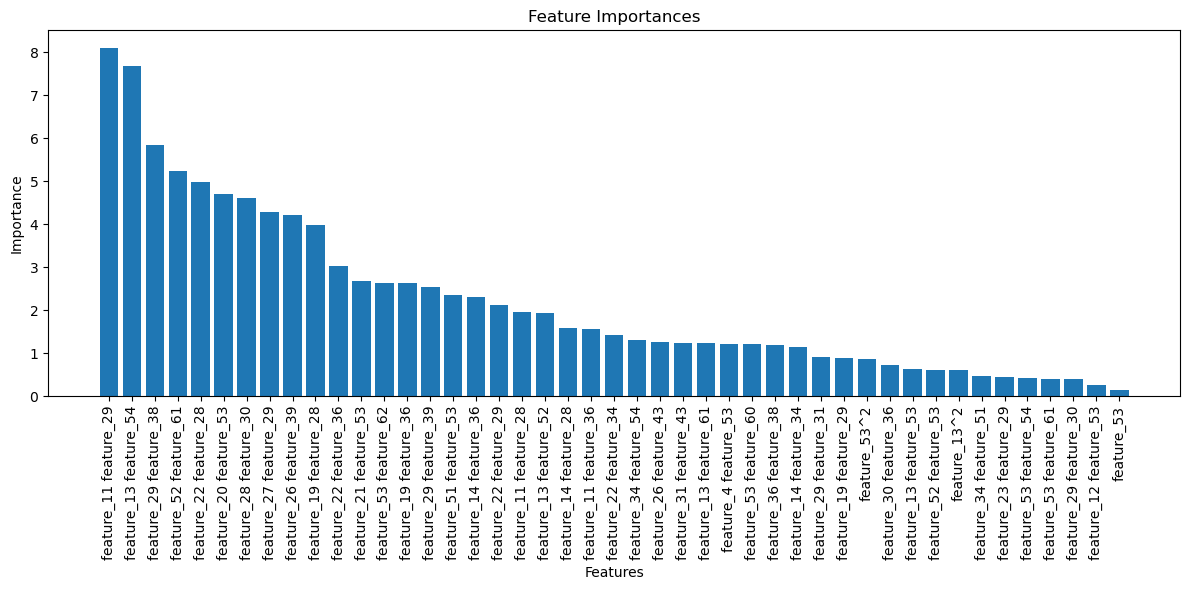

In [55]:
plot_feature_importances(feature_importances, selected_features)

In [56]:
# Sving the model pipline
joblib.dump(best_model_pipeline, '../model/best_model_pipeline.joblib')

['../model/best_model_pipeline.joblib']

In [18]:
# # Load the model pipeline
# loaded_model = joblib.load('../model/best_model_pipeline.joblib')
# # Make predictions
# y_pred = loaded_model.predict(X_test)
# y_pred

<h2 style="color:blue" align="center">Model Performance Metrics</h2>

In this section, I seek to access and discuss the performance of the model. This section will include:
<ol>
    <li>Confussion Matrix</li>
    <li>Classification Report</li>
</ol>

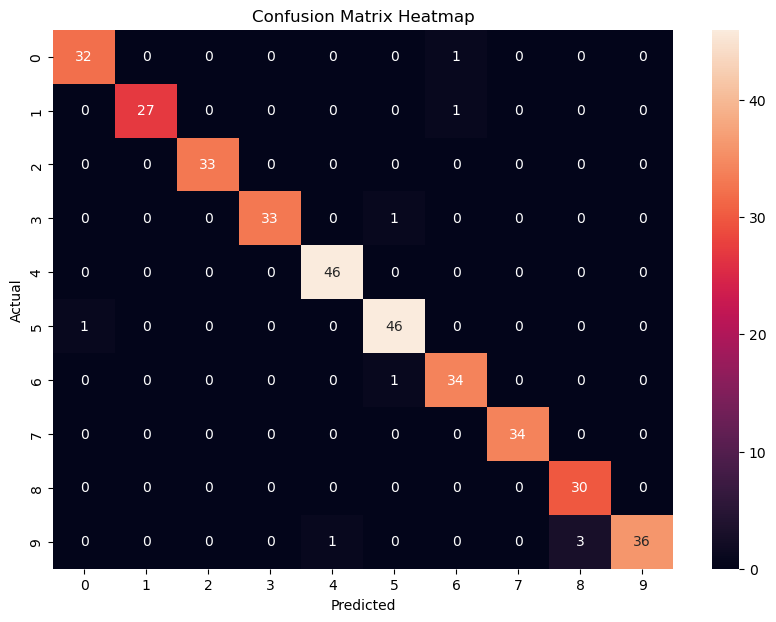

In [57]:
confusion_matrix_heatmap(y_test, y_pred)

**Most of the off-diagonal elements are zeros, which shows that the predicted differs from the acctual on <br> very few occasions, indicating that the model performed well.** 

In [58]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97        33
           1       1.00      0.96      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       0.98      1.00      0.99        46
           5       0.96      0.98      0.97        47
           6       0.94      0.97      0.96        35
           7       1.00      1.00      1.00        34
           8       0.91      1.00      0.95        30
           9       1.00      0.90      0.95        40

    accuracy                           0.97       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.97      0.97       360

